In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import sys

# Add the project root to sys.path to enable relative imports
sys.path.insert(0, r"c:\Users\Krish Patel\Workspace\Projects\stock_prediction")

from features.macro_features import get_macro_features
# from features.sentiment import build_sentiment_df
from features.flags import build_flag_dataframe
from utils import flatten_columns


## 1. Data Collection

In [5]:
now = datetime.now()
ticker = "^NSEI"
start = datetime(now.year - 10, now.month, now.day)
end = now
price_df = yf.download(ticker, start, end)

# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.mask(diff < 0, 0)
    loss = diff.mask(diff > 0, 0).abs()
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

price_df['RSI'] = calculate_rsi(price_df['Close'])

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

macd, signal_line = calculate_macd(price_df['Close'])
price_df['MACD'] = macd
price_df['MACD_Signal'] = signal_line

# Calculate EMA 50
price_df['EMA_50'] = price_df['Close'].ewm(span=50, adjust=False).mean()

# Calculate SMA 20
price_df['SMA_20'] = price_df['Close'].rolling(window=20).mean()

# Calculate Stochastic RSI
def calculate_stoch_rsi(data, window=14, k_window=3, d_window=3):
    rsi = calculate_rsi(data, window)
    min_rsi = rsi.rolling(window=window).min()
    max_rsi = rsi.rolling(window=window).max()
    stoch_rsi = (rsi - min_rsi) / (max_rsi - min_rsi)
    k_line = stoch_rsi.rolling(window=k_window).mean()
    d_line = k_line.rolling(window=d_window).mean()
    return k_line, d_line

price_df['StochRSI_K'], price_df['StochRSI_D'] = calculate_stoch_rsi(price_df['Close'])

print(price_df.columns.tolist())

C:\Users\Krish Patel\AppData\Local\Temp\ipykernel_16700\204276141.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed

[('Close', '^NSEI'), ('High', '^NSEI'), ('Low', '^NSEI'), ('Open', '^NSEI'), ('Volume', '^NSEI'), ('RSI', ''), ('MACD', ''), ('MACD_Signal', ''), ('EMA_50', ''), ('SMA_20', ''), ('StochRSI_K', ''), ('StochRSI_D', '')]


In [6]:
macro_df = get_macro_features(
    start=price_df.index.min(),
    end=price_df.index.max()
)

c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjus

In [7]:
flag_df = build_flag_dataframe(price_df.index)
flag_df = flag_df.shift(1).fillna(0)
flag_df.columns = flag_df.columns.astype(str)

c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\flags.py:40: FutureWarning: YF.download() has changed argument auto_adjust default to True
  returns = df.pct_change().fillna(0.0)
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\features\flags.py:42: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return returns


In [8]:
# news_df = pd.read_csv("../../data/news/news.csv")

# sentiment_df = build_sentiment_df(
#     news_df=news_df,
#     price_dates=price_df.index
# )

In [9]:
price_df = flatten_columns(price_df)
macro_df = macro_df.reindex(price_df.index, method="ffill")
macro_df = flatten_columns(macro_df)


final_df = pd.concat([price_df, macro_df, flag_df], axis=1)
df = flatten_columns(final_df)
df.dropna(inplace=True)
df = df.rename(columns={f"Open_{ticker}": "Open", f"Close_{ticker}": "Close"})

In [10]:
df.head()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-02,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,...,0.023869,0.028884,-0.073909,0.019259,-0.007449,0.0,0.0,0.0,0.0,0.0
2016-03-03,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,...,0.004094,0.002947,0.017140,0.007558,-0.006919,0.0,0.0,0.0,0.0,0.0
2016-03-04,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,...,0.003499,0.000850,-0.050026,-0.002597,-0.005284,0.0,0.0,0.0,0.0,0.0
2016-03-08,7485.299805,7527.149902,7442.149902,7486.399902,257000,70.802976,24.082711,-30.878211,7282.672472,7179.047534,...,0.003306,0.002039,-0.008869,0.039051,-0.003636,0.0,0.0,0.0,0.0,0.0
2016-03-09,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,...,-0.011240,-0.012623,0.032998,-0.036939,0.001733,0.0,1.0,0.0,0.0,0.0


In [11]:
df.tail()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-09,25683.300781,25940.599609,25623.000000,25840.400391,348800,40.461616,10.851184,48.472752,25902.662488,26034.217676,...,0.000077,-0.004421,0.065327,0.031613,-0.003346,0.0,0.0,0.0,0.0,0.0
2026-01-12,25790.250000,25813.150391,25473.400391,25669.050781,275800,36.203471,-8.577432,37.062715,25898.254155,26021.382715,...,0.006475,0.008149,0.031132,0.023546,0.000456,0.0,0.0,0.0,0.0,0.0
2026-01-13,25732.300781,25899.800781,25603.300781,25897.349609,339500,34.533968,-28.324264,23.985319,25891.746179,26006.632715,...,0.001578,0.002642,0.040256,0.006428,0.003677,0.0,0.0,0.0,0.0,0.0
2026-01-14,25665.599609,25791.750000,25603.949219,25648.550781,393100,33.790320,-48.793536,9.429548,25882.877686,25996.907715,...,-0.001939,-0.001013,-0.014952,0.027731,-0.001145,0.0,0.0,0.0,0.0,0.0
2026-01-16,25694.349609,25873.500000,25662.400391,25696.050781,434000,37.562085,-61.981216,-4.852605,25875.484428,25990.697656,...,-0.005333,-0.010043,0.010714,0.014227,0.001557,0.0,0.0,0.0,0.0,0.0


## 2. Data Exploraion & Visualization

In [12]:
df.shape

(2434, 22)

In [13]:
df.isna().sum()

Close                   0
High_^NSEI              0
Low_^NSEI               0
Open                    0
Volume_^NSEI            0
RSI                     0
MACD                    0
MACD_Signal             0
EMA_50                  0
SMA_20                  0
StochRSI_K              0
StochRSI_D              0
sp500_ret_^GSPC         0
nasdaq_ret_^IXIC        0
vix_ret_^INDIAVIX       0
crude_ret_CL=F          0
usd_inr_ret_USDINR=X    0
fed_policy_flag         0
global_crash_flag       0
oil_shock_flag          0
war_flag                0
india_policy_flag       0
dtype: int64

In [14]:
df.describe()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
count,2434.000000,2434.000000,2434.000000,2434.000000,2.434000e+03,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,...,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000
mean,15322.711186,15400.217971,15241.033003,15331.240552,3.386511e+05,56.115593,53.884251,53.774021,15135.258886,15249.249438,...,0.000578,0.000751,0.000329,-0.000812,0.000100,0.030813,0.149548,0.006984,0.000411,0.001643
std,5622.023862,5642.266164,5601.041448,5621.733549,1.903478e+05,17.150454,162.250867,152.966837,5551.697946,5599.541273,...,0.011233,0.013697,0.052074,0.072536,0.003573,0.172848,0.356701,0.083297,0.020269,0.040514
min,7368.850098,7380.350098,7308.149902,7321.700195,0.000000e+00,2.022397,-1005.837460,-848.332753,7257.228239,7170.752539,...,-0.119841,-0.123213,-0.297503,-3.059661,-0.022850,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10566.612305,10620.087402,10516.237549,10581.887207,2.179500e+05,43.486063,-27.206011,-22.829817,10553.796127,10563.932520,...,-0.003508,-0.004968,-0.027009,-0.011714,-0.001673,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14564.149902,14659.899902,14447.600098,14577.150391,2.809500e+05,56.059825,65.653409,63.745284,14133.836221,14579.441187,...,0.000828,0.001290,-0.004114,0.002176,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19383.638184,19441.587402,19307.724609,19385.261719,4.045000e+05,68.499094,146.952085,143.522284,19105.437445,19354.370630,...,0.005810,0.007569,0.022380,0.013680,0.001693,0.000000,0.000000,0.000000,0.000000,0.000000
max,26328.550781,26373.199219,26210.050781,26333.699219,1.811000e+06,100.000000,451.083428,413.985339,25913.035064,26044.980176,...,0.095154,0.121632,0.656250,0.376623,0.026747,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df.head()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-02,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,...,0.023869,0.028884,-0.073909,0.019259,-0.007449,0.0,0.0,0.0,0.0,0.0
2016-03-03,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,...,0.004094,0.002947,0.017140,0.007558,-0.006919,0.0,0.0,0.0,0.0,0.0
2016-03-04,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,...,0.003499,0.000850,-0.050026,-0.002597,-0.005284,0.0,0.0,0.0,0.0,0.0
2016-03-08,7485.299805,7527.149902,7442.149902,7486.399902,257000,70.802976,24.082711,-30.878211,7282.672472,7179.047534,...,0.003306,0.002039,-0.008869,0.039051,-0.003636,0.0,0.0,0.0,0.0,0.0
2016-03-09,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,...,-0.011240,-0.012623,0.032998,-0.036939,0.001733,0.0,1.0,0.0,0.0,0.0


In [16]:
df = df.reset_index()

In [17]:
df.head()

,Date,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
0,2016-03-02,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,...,0.023869,0.028884,-0.073909,0.019259,-0.007449,0.0,0.0,0.0,0.0,0.0
1,2016-03-03,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,...,0.004094,0.002947,0.017140,0.007558,-0.006919,0.0,0.0,0.0,0.0,0.0
2,2016-03-04,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,...,0.003499,0.000850,-0.050026,-0.002597,-0.005284,0.0,0.0,0.0,0.0,0.0
3,2016-03-08,7485.299805,7527.149902,7442.149902,7486.399902,257000,70.802976,24.082711,-30.878211,7282.672472,...,0.003306,0.002039,-0.008869,0.039051,-0.003636,0.0,0.0,0.0,0.0,0.0
4,2016-03-09,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,...,-0.011240,-0.012623,0.032998,-0.036939,0.001733,0.0,1.0,0.0,0.0,0.0


Text(0, 0.5, 'Close price')

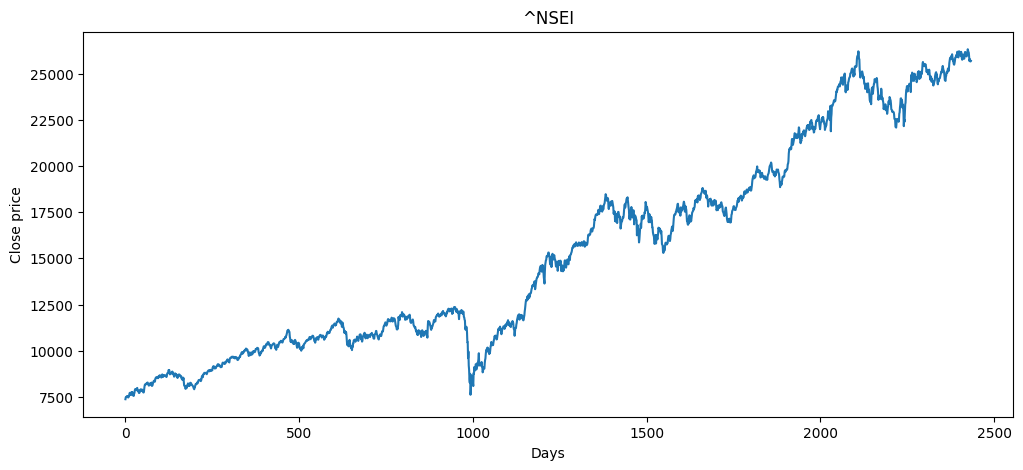

In [18]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.title(ticker)
plt.xlabel('Days')
plt.ylabel('Close price')

In [19]:
ls = df.columns.tolist()[1:]
ls

['Close',
 'High_^NSEI',
 'Low_^NSEI',
 'Open',
 'Volume_^NSEI',
 'RSI',
 'MACD',
 'MACD_Signal',
 'EMA_50',
 'SMA_20',
 'StochRSI_K',
 'StochRSI_D',
 'sp500_ret_^GSPC',
 'nasdaq_ret_^IXIC',
 'vix_ret_^INDIAVIX',
 'crude_ret_CL=F',
 'usd_inr_ret_USDINR=X',
 'fed_policy_flag',
 'global_crash_flag',
 'oil_shock_flag',
 'war_flag',
 'india_policy_flag']

## 3. Feature Engineering

In [20]:
features = df.columns.tolist()[1:]

time_step = 100
target_cols = ['Close', 'Open']
input_cols = features

data_to_process = df[features]

In [21]:
train_size = int(len(data_to_process) * 0.7)
data_training = data_to_process.iloc[:train_size]
data_testing = data_to_process.iloc[train_size:]

In [22]:
data_training.head()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
0,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,...,0.023869,0.028884,-0.073909,0.019259,-0.007449,0.0,0.0,0.0,0.0,0.0
1,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,...,0.004094,0.002947,0.017140,0.007558,-0.006919,0.0,0.0,0.0,0.0,0.0
2,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,...,0.003499,0.000850,-0.050026,-0.002597,-0.005284,0.0,0.0,0.0,0.0,0.0
3,7485.299805,7527.149902,7442.149902,7486.399902,257000,70.802976,24.082711,-30.878211,7282.672472,7179.047534,...,0.003306,0.002039,-0.008869,0.039051,-0.003636,0.0,0.0,0.0,0.0,0.0
4,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,...,-0.011240,-0.012623,0.032998,-0.036939,0.001733,0.0,1.0,0.0,0.0,0.0


In [23]:
data_testing.head()

,Close,High_^NSEI,Low_^NSEI,Open,Volume_^NSEI,RSI,MACD,MACD_Signal,EMA_50,SMA_20,...,sp500_ret_^GSPC,nasdaq_ret_^IXIC,vix_ret_^INDIAVIX,crude_ret_CL=F,usd_inr_ret_USDINR=X,fed_policy_flag,global_crash_flag,oil_shock_flag,war_flag,india_policy_flag
1703,17662.150391,17735.699219,17537.550781,17731.449219,398300,40.211335,-112.492513,-80.380651,18039.862403,17957.309863,...,-0.012969,-0.019610,0.022517,-0.022339,0.000772,0.0,1.0,0.0,0.0,0.0
1704,17616.300781,17972.199219,17353.400391,17811.599609,512900,39.373265,-125.155878,-89.335696,18023.252143,17926.497363,...,0.014642,0.016741,-0.046866,0.012452,0.000882,0.0,0.0,0.0,0.0,0.0
1705,17610.400391,17653.900391,17445.949219,17517.099609,490100,40.343007,-134.121726,-98.292902,18007.061878,17904.869922,...,0.010452,0.020007,-0.005924,-0.031191,0.002311,1.0,1.0,0.0,0.0,1.0
1706,17854.050781,17870.300781,17584.199219,17721.750000,424100,46.409988,-120.181300,-102.670582,18001.061443,17897.964941,...,0.014699,0.032540,-0.062575,-0.006936,-0.000711,0.0,0.0,0.0,0.0,0.0
1707,17764.599609,17823.699219,17698.349609,17818.550781,282500,45.526985,-115.025432,-105.141552,17991.788430,17893.222461,...,-0.010355,-0.015890,-0.084552,-0.032815,0.004107,0.0,1.0,0.0,0.0,0.0


## 4. Data Preprocessing

In [24]:
# Scaling down data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

In [25]:
train_size = int(len(df) * 0.7)
data_training = df.iloc[:train_size]
data_testing  = df.iloc[train_size:]

# Target Scaler
target_cols = ['Close', 'Open']
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(data_training[target_cols])

# Input Scaler
input_cols = features
input_scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler.fit(data_training[input_cols])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [26]:
train_x_scaled = input_scaler.transform(data_training[input_cols])
test_x_scaled = input_scaler.transform(data_testing[input_cols])

train_y_scaled = target_scaler.transform(data_training[target_cols])
test_y_scaled = target_scaler.transform(data_testing[target_cols])

In [27]:
train_x_scaled.shape

(1703, 22)

## 5. Sequence Creation

In [28]:
def create_sequences(x, y, time_step):
    xs, ys = [], []
    for i in range(time_step, len(x)):
        xs.append(x[i-time_step:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_x_scaled, train_y_scaled, time_step)

## 6. Model Building

In [29]:
import tensorflow as tf
tf.__version__

'2.20.0'

In [30]:
# ML Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

In [31]:
model = Sequential()

model.add(Input(shape=(100, x_train.shape[2])))
model.add(LSTM(units=128, activation='tanh', return_sequences=True)) # Give Sequence of output
model.add(LSTM(units=64))
model.add(Dense(25))
model.add(Dense(2))

## 7. Model Training

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0305
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.6845e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 5.7237e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.6292e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.7184e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.5395e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.0787e-04
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.8653e-04
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.3628e-04
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.7396e-04
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 3.9984e-04
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.1639e-04
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 3.8076e-04
Epoch 14/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.2159e-04
Epoch

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,193 (1.47 MB)

 Trainable params: 128,397 (501.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,796 (1003.11 KB)

In [34]:
# Save the trained model
model.save('Model_v1.keras')

## 8. Preparing Test Data

In [35]:
test_input_x = np.concatenate(
    (train_x_scaled[-time_step:], test_x_scaled),
    axis=0
)

test_input_y = np.concatenate(
    (train_y_scaled[-time_step:], test_y_scaled),
    axis=0
)

x_test, y_test = create_sequences(test_input_x, test_input_y, time_step)



In [36]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1603, 100, 22) (1603, 2)
(731, 100, 22) (731, 2)


## 9. Making Prediction

In [37]:
y_predicted = model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [38]:
y_pred_actual = target_scaler.inverse_transform(y_predicted)
y_test_actual = target_scaler.inverse_transform(y_test)

In [39]:
# Means should be close
print(y_test_actual[:,0].mean(), y_pred_actual[:,0].mean())

22510.60824213406 22299.162


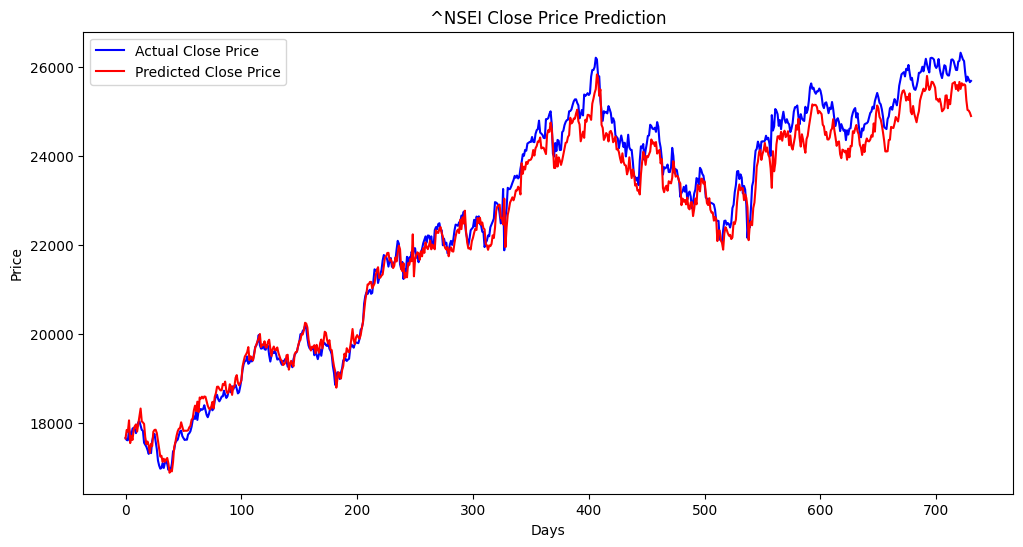

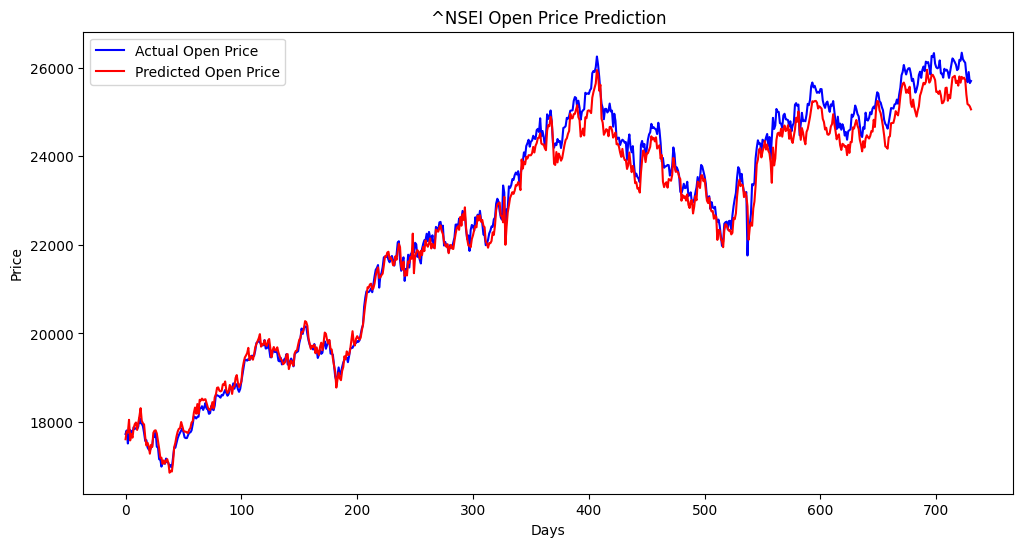

In [40]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 0], 'b', label='Actual Close Price')
plt.plot(y_pred_actual[:, 0], 'r', label='Predicted Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"{ticker} Close Price Prediction")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 1], 'b', label='Actual Open Price')
plt.plot(y_pred_actual[:, 1], 'r', label='Predicted Open Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"{ticker} Open Price Prediction")
plt.legend()
plt.show()

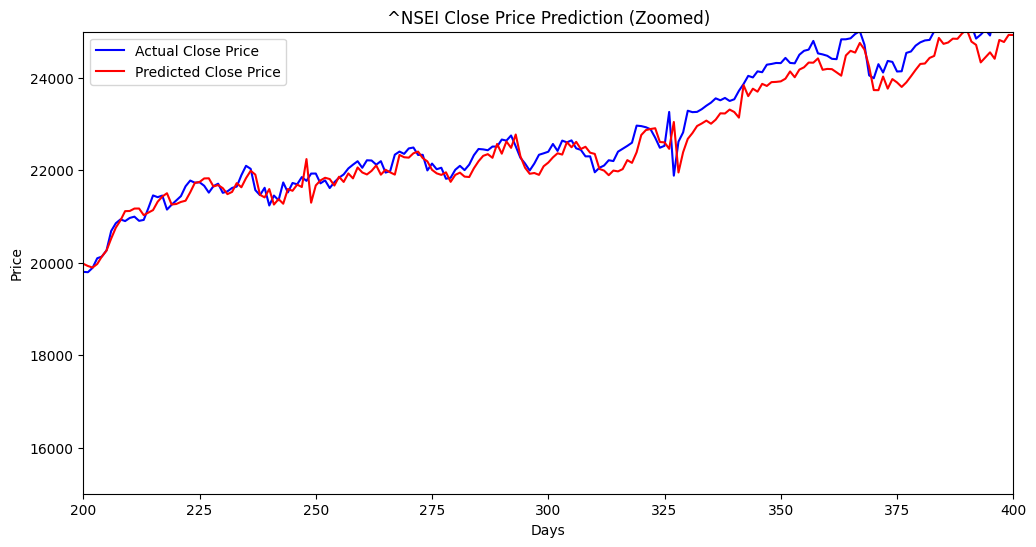

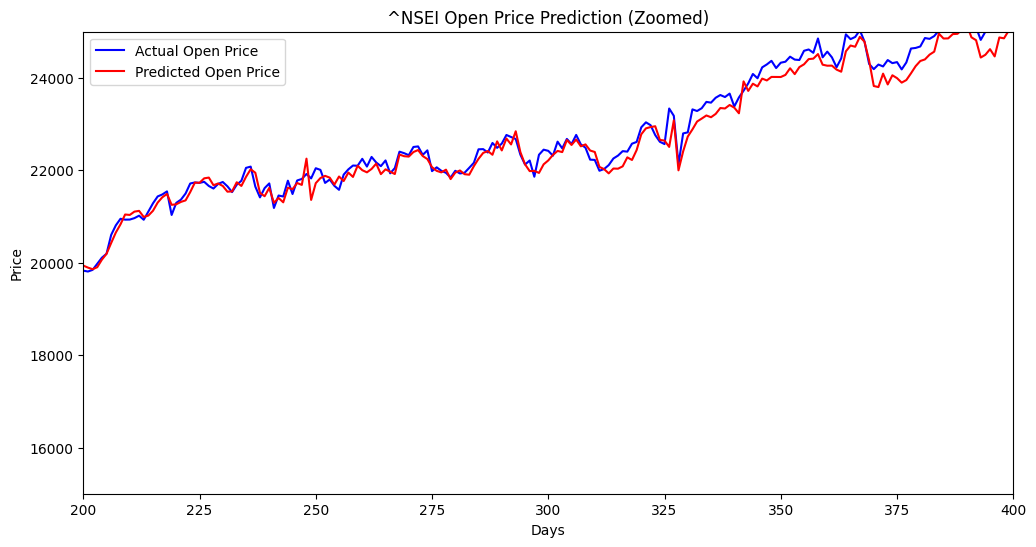

In [41]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 0], 'b', label = 'Actual Close Price')
plt.plot(y_pred_actual[:, 0], 'r', label = 'Predicted Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.xlim(200, 400)
plt.ylim(15000, 25000)
plt.title(f"{ticker} Close Price Prediction (Zoomed)")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 1], 'b', label = 'Actual Open Price')
plt.plot(y_pred_actual[:, 1], 'r', label = 'Predicted Open Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.xlim(200, 400)
plt.ylim(15000, 25000)
plt.title(f"{ticker} Open Price Prediction (Zoomed)")
plt.show()

## 10. Model Evaluation

In [42]:
# MSE
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
# Calculate MSE for Close and Open prices separately
mse_close = mean_squared_error(y_test[:, 0], y_predicted[:, 0])
mse_open = mean_squared_error(y_test[:, 1], y_predicted[:, 1])

print(f"Mean Squred Error (MSE) for Close Price: {mse_close}")
print(f"Mean Squred Error (MSE) for Open Price: {mse_open}")

Mean Squred Error (MSE) for Close Price: 0.0011194332817004368
Mean Squred Error (MSE) for Open Price: 0.0006327469309548615


In [44]:
# Calculate RMSE for Close and Open prices separately
rmse_close = np.sqrt(mean_squared_error(y_test[:, 0], y_predicted[:, 0]))
rmse_open = np.sqrt(mean_squared_error(y_test[:, 1], y_predicted[:, 1]))

print(f"Root Mean Squred Error (RMSE) for Close Price: {rmse_close}")
print(f"Root Mean Squred Error (RMSE) for Open Price: {rmse_open}")

Root Mean Squred Error (RMSE) for Close Price: 0.03345793301595956
Root Mean Squred Error (RMSE) for Open Price: 0.025154461452292345


In [45]:
np.mean(
    np.sign(y_pred_actual[1:] - y_test_actual[:-1]) ==
    np.sign(y_test_actual[1:] - y_test_actual[:-1])
)


np.float64(0.560958904109589)

In [46]:
# Calculate R-Squared for Close and Open prices separately
r2_close = r2_score(y_test[:, 0], y_predicted[:, 0])
r2_open = r2_score(y_test[:, 1], y_predicted[:, 1])

print(f"R-Squared for Close Price: {r2_close}")
print(f"R-Squared for Open Price: {r2_open}")

R-Squared for Close Price: 0.9794692313769806
R-Squared for Open Price: 0.9881689685117019


In [47]:
# Print model confidence for Close and Open prices separately
r2_close = r2_score(y_test[:, 0], y_predicted[:, 0])
r2_open = r2_score(y_test[:, 1], y_predicted[:, 1])

print(f"Model Confidence (R-squared) for Close Price: {(r2_close * 100):.2f}%")
print(f"Model Confidence (R-squared) for Open Price: {(r2_open * 100):.2f}%")

Model Confidence (R-squared) for Close Price: 97.95%
Model Confidence (R-squared) for Open Price: 98.82%


In [48]:
import numpy as np

def directional_accuracy(y_true, y_pred, prev_close):
    """
    y_true: actual Close(t+1)
    y_pred: predicted Close(t+1)
    prev_close: Close(t)
    """
    true_dir = np.sign(y_true - prev_close)
    pred_dir = np.sign(y_pred - prev_close)

    # remove zero-move days
    mask = true_dir != 0
    return np.mean(true_dir[mask] == pred_dir[mask])


In [49]:
prev_close_actual = (
    price_df["Close_^NSEI"]
    .shift(1)
    .iloc[-len(y_test_actual):]
    .values
)

# Compute directional accuracy for Close prices
acc_close = directional_accuracy(
    y_true=y_test_actual[:, 0],
    y_pred=y_pred_actual[:, 0],
    prev_close=prev_close_actual
)

# Compute directional accuracy for Open prices
acc_open = directional_accuracy(
    y_true=y_test_actual[:, 1],
    y_pred=y_pred_actual[:, 1],
    prev_close=prev_close_actual
)

print("Directional accuracy for Close:", acc_close)
print("Directional accuracy for Open:", acc_open)


Directional accuracy for Close: 0.5205479452054794
Directional accuracy for Open: 0.466484268125855
